In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import cupyx.scipy.fft as cufft
from time import time

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
import covseisnet as csn
from covseisnet.cudaseisnet import (
    coherence,
    calculate,
    stft,
    calculate_eigenvalues,
    calculate_eigenvectors,
    xcov,
    flatten
)


## Download data and put into cosvseisnet ArrayStream

In [153]:
# example from csn docs (plot_example_5.py)


# # download data from the YA Undervolc seismic network with RESIF Seismic data portal

# was having problems downloading data so grabbed some form SCEDC
client = Client("IRIS")
signal_duration_sec = 3600 #24 * 3600
t = UTCDateTime("2020-10-14T00:00:00.00")
list_stations = [
    "BAR",
    "BEL",
    "ARV",
    "ADO",
]
stream = csn.arraystream.ArrayStream()
for sta in list_stations:
    print(sta)
    st = client.get_waveforms(
        network="CI", station=sta, location="*", channel="HHZ",
        starttime=t, endtime=t + signal_duration_sec
    )
    stream.append(st[0])

#stream = csn.arraystream.ArrayStream(obspy.read())
raw_stream = stream.copy()

# create plot #1 - no preprocessing

# downsample data to 25 Hz
stream.decimate(4)

# synchronize data
stream = stream.synchronize(start=stream[0].stats.starttime, duration_sec=signal_duration_sec, method="linear")



BAR
BEL
ARV
ADO


In [154]:
stream

4 Trace(s) in Stream:
CI.BAR..HHZ | 2020-10-14T00:00:00.008393Z - 2020-10-14T00:59:59.968393Z | 25.0 Hz, 90000 samples
CI.BEL..HHZ | 2020-10-14T00:00:00.008393Z - 2020-10-14T00:59:59.968393Z | 25.0 Hz, 90000 samples
CI.ARV..HHZ | 2020-10-14T00:00:00.008393Z - 2020-10-14T00:59:59.968393Z | 25.0 Hz, 90000 samples
CI.ADO..HHZ | 2020-10-14T00:00:00.008393Z - 2020-10-14T00:59:59.968393Z | 25.0 Hz, 90000 samples

### Regular covseisnet

In [256]:
# calculate covariance from stream
window_duration_sec = 10
average = 15
t0 = time()
times, frequencies, covariances = csn.covariancematrix.calculate(
    stream, window_duration_sec, average
)

# calculate spectral width
spectral_width_cpu = covariances.coherence(kind="spectral_width")

print(f"Total time {(time()-t0):.1f} s")

Total time 1.7 s


### GPU version

In [156]:
# create gpu matrix
# free memory - only needed if doing this multiple times and the buffer fills
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()
# this following is now a function in utils
array = cp.stack([cp.asarray(trace.data) for trace in stream.traces])#.astype("float32")
array.device, array.shape

(<CUDA Device 0>, (4, 90000))

In [282]:
# gpu covseisnet

window_duration_sec = 10
average = 15
fs = stream[0].stats.sampling_rate

t0 = time()

timesg, frequenciesg, covariancesg = calculate(
    array, window_duration_sec, average, fs
)
# calculate spectral width
t1 = time()
spectral_width_gpu = coherence(covariances, type="spectral width")

tend = time()
print(f"coherence time {(tend-t1):.1f} s")
print(f"Total time {(tend-t0):.1f} s")

torch.Size([50399, 4])
coherence time 0.0 s
Total time 0.1 s


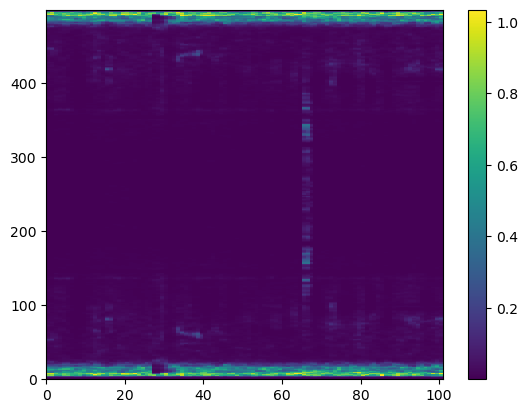

In [283]:
plt.pcolormesh(spectral_width_cpu.T, cmap="viridis")
plt.colorbar();

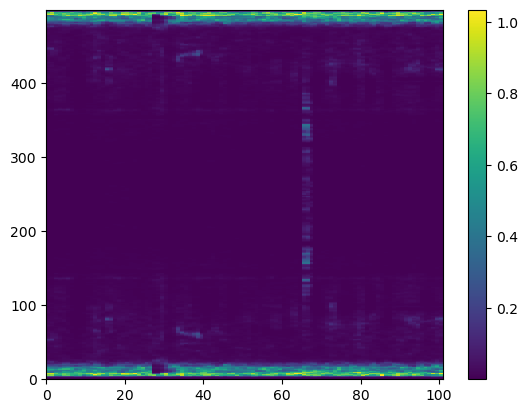

In [284]:
plt.pcolormesh(spectral_width_gpu.get().T, cmap="viridis")
plt.colorbar();